In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 20

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_error

In [2]:
raw_all = pd.read_csv('bike-sharing-demand/Full.csv')

In [3]:
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace = True)

    raw = raw.asfreq('H', method = 'ffill')
    raw_nfe = raw.copy()
    return raw_nfe

def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe

In [4]:
raw_nfe = non_feature_engineering(raw_all)

In [5]:
raw_fe1 = feature_engineering(raw_all)

In [6]:
raw_fe1

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,11,...,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,8,...,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,7,...,8,12,31,21,0,89.00,119.00,0,0,1


In [7]:
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size = test_size,
                                                        random_state = random_state)
    return X_train, X_test, Y_train, Y_test

def datasplit_ts(raw, Y_colname, X_colname, test_size, random_state, criteria):
    raw_train = raw.loc[raw.index < criteria]
    raw_test = raw.loc[raw.index >= criteria]

    X_train = raw_train[X_colname]
    Y_train = raw_train[Y_colname]
    X_test = raw_test[X_colname]
    Y_test = raw_test[Y_colname]

    return X_train, X_test, Y_train, Y_test

In [8]:
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe1.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe1, Y_colname, X_colname, 0.2, 123, '2012-07-01')

In [9]:
raw_fe1.describe(include = 'all').T# 24개의 X_train 데이터의 통계량을 보여줘

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29 00:00:00,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaN,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaN,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
temp,"17,544.00",NaN,NaN,NaN,NaT,NaT,20.30,7.92,0.82,13.94,20.50,27.06,41.00
atemp,"17,544.00",NaN,NaN,NaN,NaT,NaT,23.71,8.62,0.00,16.66,24.24,31.06,50.00
humidity,"17,544.00",NaN,NaN,NaN,NaT,NaT,62.87,19.34,0.00,48.00,63.00,79.00,100.00
windspeed,"17,544.00",NaN,NaN,NaN,NaT,NaT,12.81,8.29,0.00,7.00,13.00,17.00,57.00
casual,"17,544.00",NaN,NaN,NaN,NaT,NaT,35.35,49.19,0.00,4.00,16.00,48.00,367.00


In [10]:
fit_reg1 = sm.OLS(Y_train, X_train).fit() # stats 모델 안에 Ordinary least square를 사용해서 Y_train과 X_train의 데이터를 반영해서
fit_reg1.summary()                        # fit(적합한다)한다.
# R-squared: 모든 예측 값들이 실제 값들과 동일하는지를 의미한다
# F-statistic: 데이터들은 선형적인가? 값이 크면 선형이 잘 안그려짐, 작으면 선형이 잘 그려짐
# p-value == Prob(F-statistic): 이 값이 0.05보다 작으면 분석한 모델링이 효과가 있다는 의미 / 모델은 데이터 패턴을 잘 추정한다
# t-검정: 
# skewness: 분포의 비대칭도, 왼쪽으로 치우침 skew > 0, 오른쪽으로 치우침 skew < 0
# kurtosis: 확률분포의 뾰족한 정도, 정규분포이면 0, 위로 뾰족함 0보다 큼, 아래로 뾰족함이면 0보다 작음

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Fri, 25 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:31:33   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.832
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
pred_tr_reg1 = fit_reg1.predict(X_train).values # X_train에서 예측한(predict) 값(values)을 pred 변수에 저장해라
pred_te_reg1 = fit_reg1.predict(X_test).values

In [12]:
# code Summary
fit_reg1 = sm.OLS(Y_train, X_train).fit()
pred_tr_reg1 = fit_reg1.predict(X_train).values
pred_te_reg1 = fit_reg1.predict(X_test).values

In [13]:
'''
1. 시각화를 먼저 하면서 X와 Y가 관련이 있는지 미리 생각하고 알고리즘을 만드는 습관을 가져야 함
2. 시각화를 통해 데이터의 특성을 알아가는 방법을 학습함
3. 시각화의 가장 큰 목적
- X1, X2 ;;; X24 변수들이 Y와 관련이 있는지 눈으로 확인하는 것 즉 요약하자면 독립변수와 종속변수의 관계성을 눈으로 확인하는 과정이다
- Y와 X의 관련성이 높은게 좋음
- X1, X2의 관련성은 낮아야 좋음
- X는 독립변수, Y는 종속 변수라 불린다
- X들의 관계는 낮아야 하고 종속 변수인 Y는 X의 의존도가 높아야 좋은 모델이다
'''

'\n1. 시각화를 먼저 하면서 X와 Y가 관련이 있는지 미리 생각하고 알고리즘을 만드는 습관을 가져야 함\n2. 시각화를 통해 데이터의 특성을 알아가는 방법을 학습함\n3. 시각화의 가장 큰 목적\n- X1, X2 ;;; X24 변수들이 Y와 관련이 있는지 눈으로 확인하는 것 즉 요약하자면 독립변수와 종속변수의 관계성을 눈으로 확인하는 과정이다\n- Y와 X의 관련성이 높은게 좋음\n- X1, X2의 관련성은 낮아야 좋음\n- X는 독립변수, Y는 종속 변수라 불린다\n- X들의 관계는 낮아야 하고 종속 변수인 Y는 X의 의존도가 높아야 좋은 모델이다\n'

In [14]:
raw_fe1.describe(include = 'all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,17544,17379,2012-10-29 00:00:00,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,"17,544.00",NaN,NaN,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"17,544.00",NaN,NaN,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
temp,"17,544.00",NaN,NaN,NaN,NaT,NaT,20.30,7.92,0.82,13.94,20.50,27.06,41.00
atemp,"17,544.00",NaN,NaN,NaN,NaT,NaT,23.71,8.62,0.00,16.66,24.24,31.06,50.00
humidity,"17,544.00",NaN,NaN,NaN,NaT,NaT,62.87,19.34,0.00,48.00,63.00,79.00,100.00
windspeed,"17,544.00",NaN,NaN,NaN,NaT,NaT,12.81,8.29,0.00,7.00,13.00,17.00,57.00
casual,"17,544.00",NaN,NaN,NaN,NaT,NaT,35.35,49.19,0.00,4.00,16.00,48.00,367.00


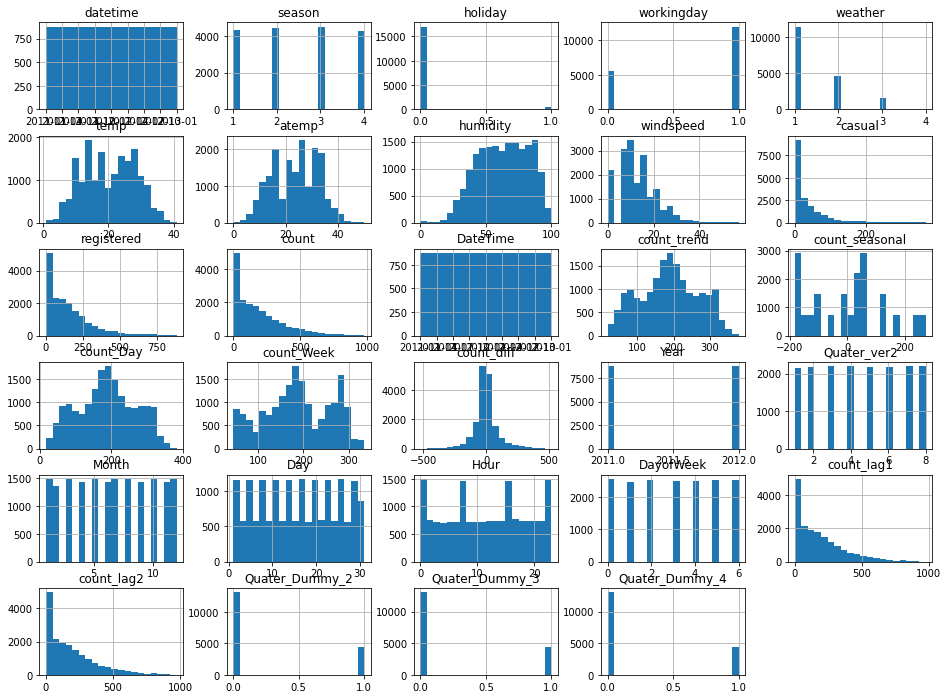

'\nraw_fe 데이터 프레임에서 히스토그램 그리는 방식은 bin(몇 개의 그룹으로 나눌 것인가?\ncount를 보면 정규 분포가 아닌 포화분포인데 여기서 count가 종속 변수인데 count와 비슷한 모형의 분포를 가진것들이 상관성이 높게 나타남\n'

In [15]:
# histogram plot
raw_fe1.hist(bins = 20, grid = True, figsize = (16, 12))
plt.show()
'''
raw_fe 데이터 프레임에서 히스토그램 그리는 방식은 bin(몇 개의 그룹으로 나눌 것인가?
count를 보면 정규 분포가 아닌 포화분포인데 여기서 count가 종속 변수인데 count와 비슷한 모형의 분포를 가진것들이 상관성이 높게 나타남
'''

'\nboxplot은 중앙값, 상단 25%, 하단 75%를 같이 볼 수 있는 지표인데\ny축은 count, registered, casual로 보고 season별 boxplot을 본다\n\n지표를 해석하는 방법은\n우선 계절별로 count의 데이터 분포가 똑같다면 계절에 의한 count는 패턴이 없다는 것을 의미한다\n즉 계절별로 데이터의 분포 패턴이 달라야 Y의 패턴을 분석하는데 많은 도움을 줌\n'

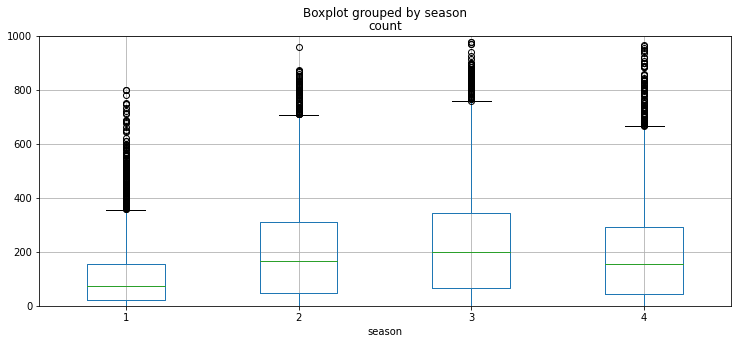

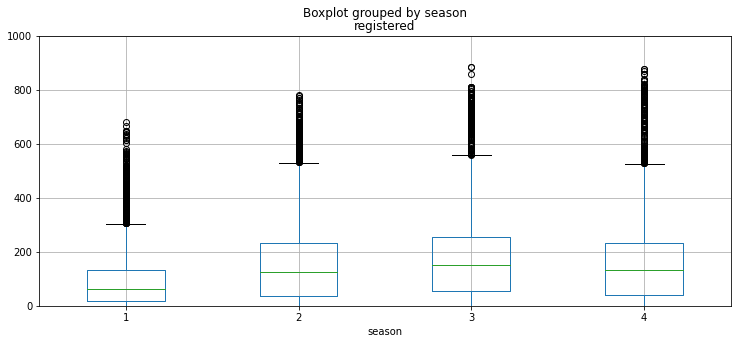

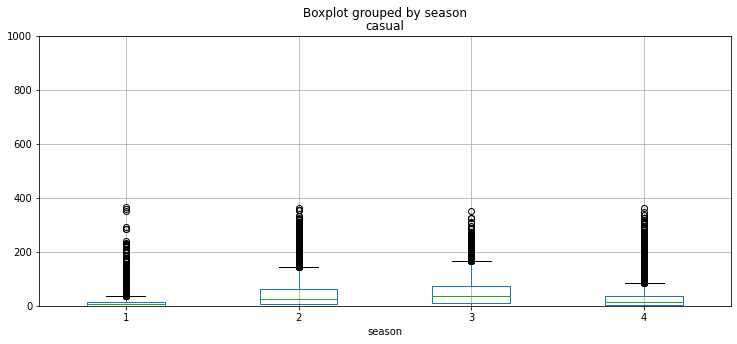

In [16]:
# box plot
raw_fe1.boxplot(column = 'count', by = 'season', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)
raw_fe1.boxplot(column = 'registered', by = 'season', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)
raw_fe1.boxplot(column = 'casual', by = 'season', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)
'''
boxplot은 중앙값, 상단 25%, 하단 75%를 같이 볼 수 있는 지표인데
y축은 count, registered, casual로 보고 season별 boxplot을 본다

지표를 해석하는 방법은
우선 계절별로 count의 데이터 분포가 똑같다면 계절에 의한 count는 패턴이 없다는 것을 의미한다
즉 계절별로 데이터의 분포 패턴이 달라야 Y의 패턴을 분석하는데 많은 도움을 줌
'''

"\n여기서 holiday x축 '0'은 holiday가 아닌 것을 의미하고 '1'은 holiday인 것을 의미한다\n즉 holiday가 아니고 workingday일 때 자전거 수요가 더 많음\n"

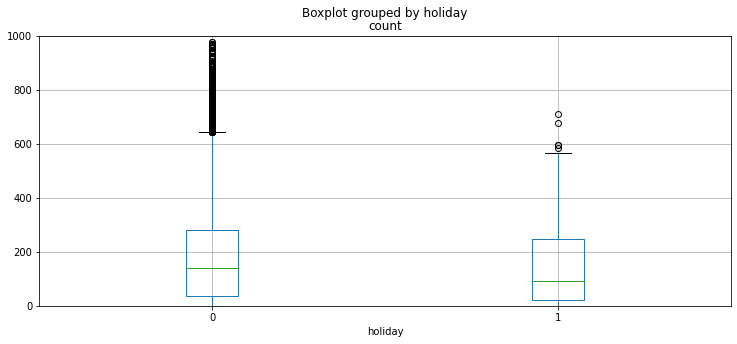

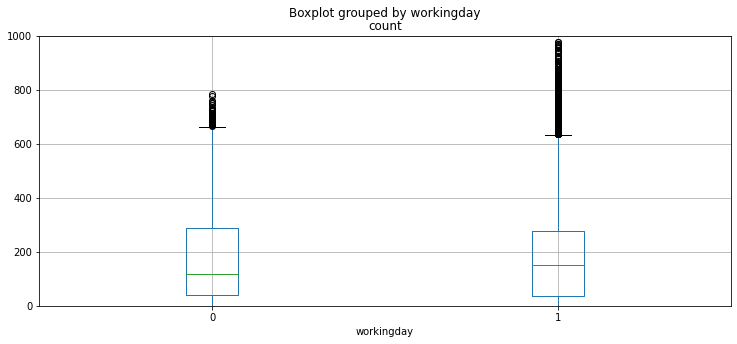

In [17]:
# box plot
raw_fe1.boxplot(column = 'count', by = 'holiday', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)
raw_fe1.boxplot(column = 'count', by = 'workingday', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)

'''
여기서 holiday x축 '0'은 holiday가 아닌 것을 의미하고 '1'은 holiday인 것을 의미한다
즉 holiday가 아니고 workingday일 때 자전거 수요가 더 많음
'''

In [18]:
raw_all[raw_all.holiday == 1] # raw_all.holiday == 1은 raw_all의 holiday가 1인 것만 출력하라는 의미

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,DateTime
DateTime,,,,,,,,,,,,,
2011-01-17 00:00:00,2011-01-17 00:00:00,1,1,0,2,8.20,9.85,47,15.00,1,16,17,2011-01-17 00:00:00
2011-01-17 01:00:00,2011-01-17 01:00:00,1,1,0,2,8.20,9.85,44,13.00,1,15,16,2011-01-17 01:00:00
2011-01-17 02:00:00,2011-01-17 02:00:00,1,1,0,2,7.38,8.34,43,17.00,0,8,8,2011-01-17 02:00:00
2011-01-17 03:00:00,2011-01-17 03:00:00,1,1,0,2,7.38,9.09,43,13.00,0,2,2,2011-01-17 03:00:00
2011-01-17 04:00:00,2011-01-17 04:00:00,1,1,0,2,7.38,9.85,43,9.00,1,2,3,2011-01-17 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-25 19:00:00,2012-12-25 19:00:00,1,1,0,2,13.12,15.15,66,15.00,16,20,36,2012-12-25 19:00:00
2012-12-25 20:00:00,2012-12-25 20:00:00,1,1,0,2,13.12,15.15,66,19.00,11,29,40,2012-12-25 20:00:00
2012-12-25 21:00:00,2012-12-25 21:00:00,1,1,0,2,12.30,14.39,65,13.00,8,26,34,2012-12-25 21:00:00


<AxesSubplot:title={'center':'count'}, xlabel='Hour'>

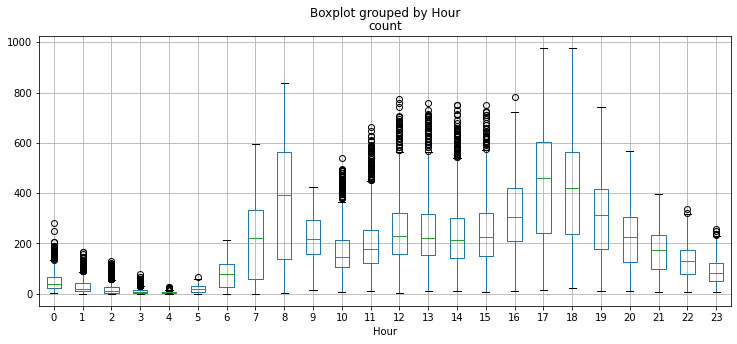

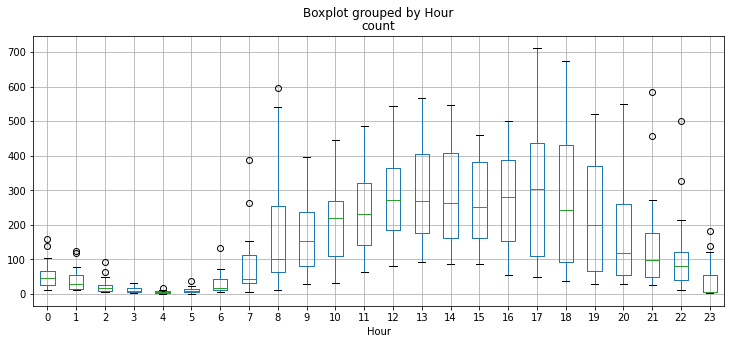

In [19]:
raw_fe1[raw_fe1.holiday == 0].boxplot(column = 'count', by = 'Hour', grid = True, figsize = (12, 5))
raw_fe1[raw_fe1.holiday == 1].boxplot(column = 'count', by = 'Hour', grid = True, figsize = (12, 5))

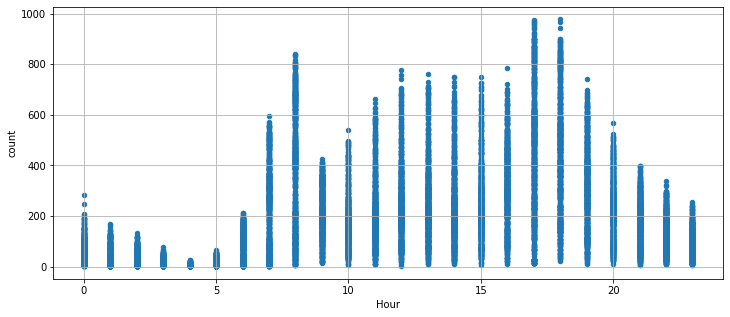

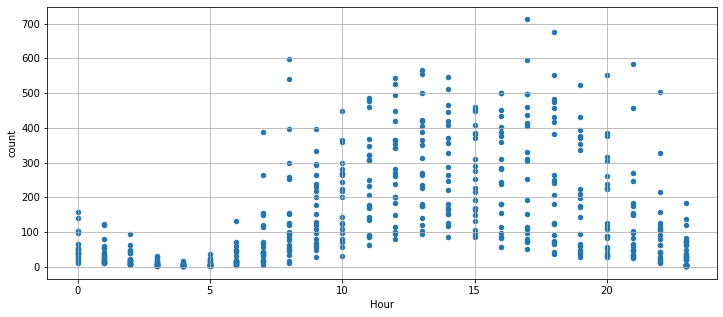

In [20]:
# scatter plot
raw_fe1[raw_fe1.holiday == 0].plot.scatter(y = 'count', x = 'Hour', grid = True, figsize = (12, 5))
plt.show()
raw_fe1[raw_fe1.holiday == 1].plot.scatter(y = 'count', x = 'Hour', grid = True, figsize = (12, 5))
plt.show()

<AxesSubplot:xlabel='Hour', ylabel='count'>

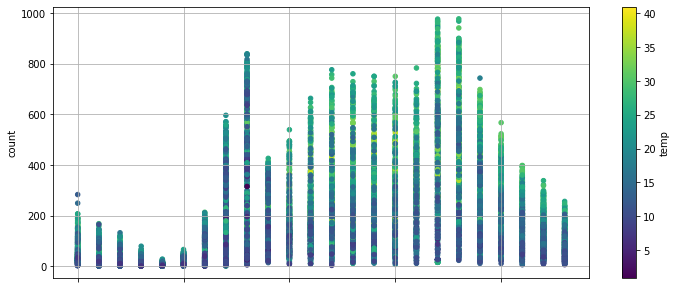

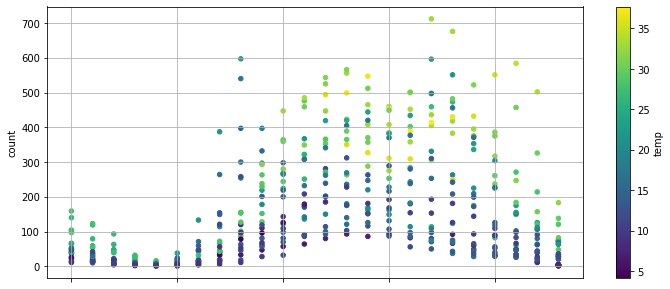

In [21]:
raw_fe1[raw_fe1.holiday == 0].plot.scatter(y = 'count', x = 'Hour', c = 'temp', grid = True, figsize = (12, 5), colormap = 'viridis')
raw_fe1[raw_fe1.holiday == 1].plot.scatter(y = 'count', x = 'Hour', c = 'temp', grid = True, figsize = (12, 5), colormap = 'viridis')

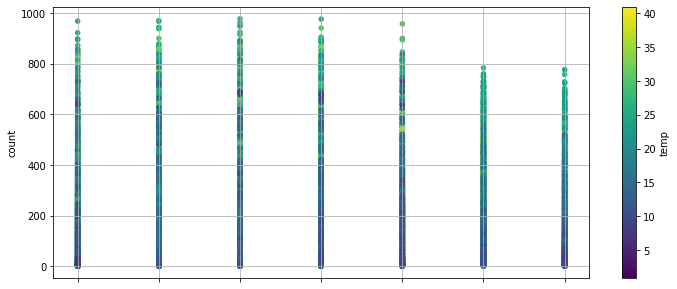

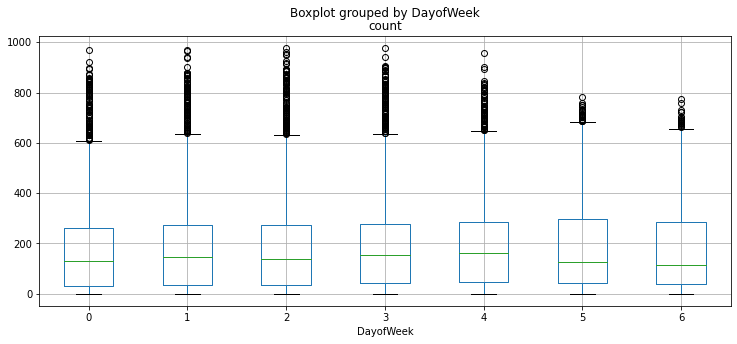

In [22]:
# scatter and box plot
raw_fe1.plot.scatter(y = 'count', x = 'DayofWeek', c = 'temp', grid = True, figsize = (12, 5), colormap = 'viridis')
plt.show()
raw_fe1.boxplot(column = 'count', by = 'DayofWeek', grid = True, figsize = (12, 5))
plt.show()

(0.0, 1000.0)

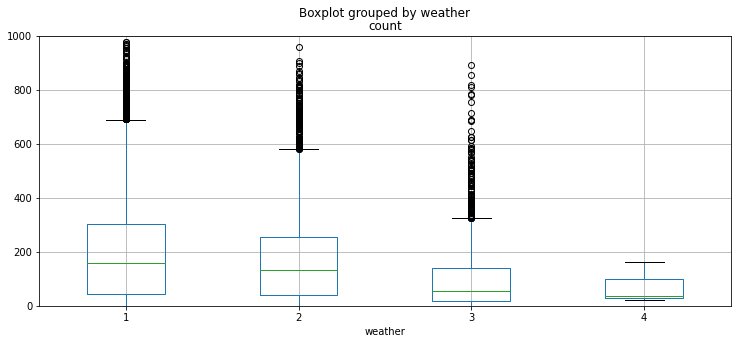

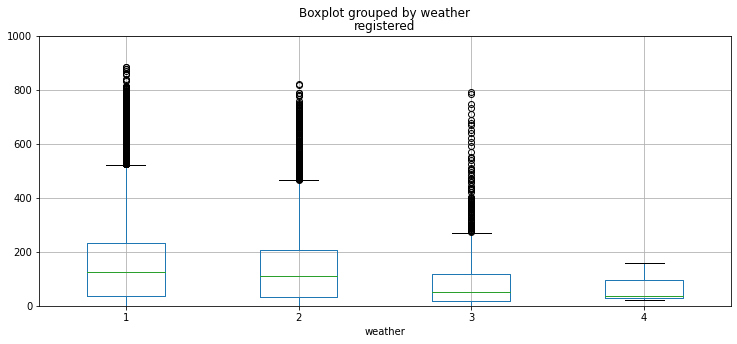

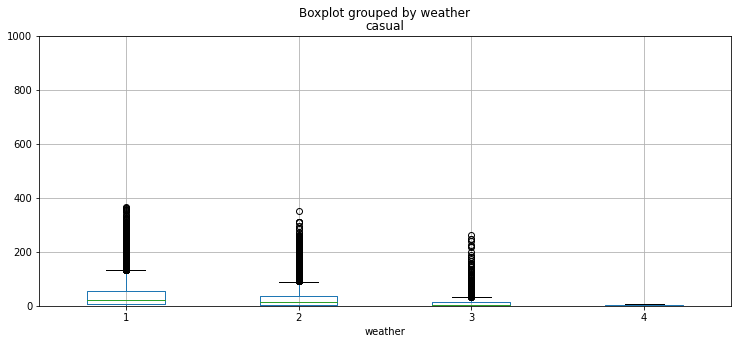

In [25]:
raw_fe1.boxplot(column = 'count', by = 'weather', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)
raw_fe1.boxplot(column = 'registered', by = 'weather', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)
raw_fe1.boxplot(column = 'casual', by = 'weather', grid = True, figsize = (12, 5))
plt.ylim(0, 1000)

In [27]:
pd.concat([raw_fe1.dtypes, raw_fe1.describe(include = 'all').T], axis = 1) # 24개의 통계 자료 요약 + 데이터 타입

,0,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,datetime64[ns],17544,17379,2012-10-29 00:00:00,37,2011-01-01,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,int64,"17,544.00",NaN,NaN,NaN,NaT,NaT,2.50,1.11,1.00,2.00,3.00,3.00,4.00
holiday,int64,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,int64,"17,544.00",NaN,NaN,NaN,NaT,NaT,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,int64,"17,544.00",NaN,NaN,NaN,NaT,NaT,1.43,0.65,1.00,1.00,1.00,2.00,4.00
temp,float64,"17,544.00",NaN,NaN,NaN,NaT,NaT,20.30,7.92,0.82,13.94,20.50,27.06,41.00
atemp,float64,"17,544.00",NaN,NaN,NaN,NaT,NaT,23.71,8.62,0.00,16.66,24.24,31.06,50.00
humidity,int64,"17,544.00",NaN,NaN,NaN,NaT,NaT,62.87,19.34,0.00,48.00,63.00,79.00,100.00
windspeed,float64,"17,544.00",NaN,NaN,NaN,NaT,NaT,12.81,8.29,0.00,7.00,13.00,17.00,57.00
casual,int64,"17,544.00",NaN,NaN,NaN,NaT,NaT,35.35,49.19,0.00,4.00,16.00,48.00,367.00


In [28]:
raw_fe1['weather'].value_counts() #데이터 값의 분포를 볼 수 있음

1    11455
2     4563
3     1523
4        3
Name: weather, dtype: int64

In [30]:
pd.DataFrame(raw_fe1['weather'].value_counts()/raw_fe1['weather'].value_counts().sum()*100).T # 데이터 분포를 퍼센테이지로 볼 수 있음

,1,2,3,4
weather,65.29,26.01,8.68,0.02


In [32]:
pd.crosstab(index = raw_fe1['count'], columns = raw_fe1['weather'], margins = True)

weather,1,2,3,4,All
count,,,,,
1,100,45,27,0,172
2,136,59,37,0,232
3,136,66,41,0,243
4,149,62,36,0,247
5,164,63,36,0,263
...,...,...,...,...,...
968,1,0,0,0,1
970,1,0,0,0,1
976,1,0,0,0,1


In [38]:
# generate cross table
sub_table = pd.crosstab(index = raw_fe1['count'], columns=raw_fe1['weather'], margins = True)
sub_table/sub_table.loc['All']*100

weather,1,2,3,4,All
count,,,,,
1,0.87,0.99,1.77,0.00,0.98
2,1.19,1.29,2.43,0.00,1.32
3,1.19,1.45,2.69,0.00,1.39
4,1.30,1.36,2.36,0.00,1.41
5,1.43,1.38,2.36,0.00,1.50
...,...,...,...,...,...
968,0.01,0.00,0.00,0.00,0.01
970,0.01,0.00,0.00,0.00,0.01
976,0.01,0.00,0.00,0.00,0.01


In [40]:
raw_fe1.groupby('weather').describe().T

weather                      1        2        3    4
season         count 11,455.00 4,563.00 1,523.00 3.00
               mean       2.51     2.49     2.45 1.00
               std        1.09     1.15     1.16 0.00
               min        1.00     1.00     1.00 1.00
               25%        2.00     1.00     1.00 1.00
...                        ...      ...      ...  ...
Quater_Dummy_4 min        0.00     0.00     0.00 0.00
               25%        0.00     0.00     0.00 0.00
               50%        0.00     0.00     0.00 0.00
               75%        0.00     1.00     1.00 0.00
               max        1.00     1.00     1.00 0.00

[208 rows x 4 columns]

In [41]:
raw_fe1.groupby(['weather', 'DayofWeek']).count()
raw_fe1.groupby(['weather', 'DayofWeek']).mean()

season  holiday  workingday  temp  atemp  humidity  \
weather DayofWeek                                                       
1       0            2.45     0.14        0.86 20.70  24.23     59.05   
        1            2.48     0.00        1.00 21.36  24.89     57.11   
        2            2.50     0.01        0.99 21.61  25.08     58.23   
        3            2.53     0.03        0.97 21.35  24.88     55.85   
        4            2.56     0.03        0.97 20.71  24.00     57.06   
        5            2.52     0.00        0.00 20.43  23.84     56.15   
        6            2.50     0.00        0.00 20.32  23.80     58.33   
2       0            2.59     0.16        0.84 19.72  23.20     68.87   
        1            2.51     0.02        0.98 19.85  23.37     71.91   
        2            2.56     0.00        1.00 19.61  23.00     70.45   
        3            2.54     0.00        1.00 19.95  23.39     70.67   
        4            2.38     0.01        0.99 19.44  22.61     66.64   
        5            2.41     0.00        0.00 18.81  22.06     69.69   
        6            2.41     0.00        0.00 18.36  21.70     71.30   
3       0            2.48     0.17        0.83 17.36  20.43     83.95   
        1            2.82     0.00        1.00 19.97  23.27     84.92   
        2            2.34     0.00        1.00 17.53  20.39     86.04   
        3            2.33     0.00        1.00 18.14  21.05     73.08   
        4            2.26     0.00        1.00 19.90  22.87     81.68   
        5            2.31     0.00        0.00 17.50  20.48     86.43   
        6            2.62     0.00        0.00 19.17  22.40     81.39   
4       0            1.00     0.00        1.00  8.20  11.37     86.00   
        2            1.00     0.00        1.00  9.02   9.85     93.00   
        5            1.00     0.00        0.00  5.74   6.82     86.00   

                   windspeed  casual  registered  count  ...     Year  \
weather DayofWeek                                        ...            
1       0              12.86   30.40      160.04 190.43  ... 2,011.49   
        1              12.95   27.57      186.58 214.14  ... 2,011.51   
        2              12.22   26.65      181.52 208.17  ... 2,011.53   
        3              13.01   28.95      184.81 213.77  ... 2,011.54   
        4              12.73   33.50      168.64 202.14  ... 2,011.49   
        5              12.98   68.51      138.94 207.45  ... 2,011.50   
        6              12.58   63.25      130.72 193.96  ... 2,011.48   
2       0              11.75   27.82      153.35 181.17  ... 2,011.50   
        1              11.80   18.46      145.10 163.56  ... 2,011.47   
        2              12.42   20.09      163.88 183.97  ... 2,011.53   
        3              12.47   18.66      157.31 175.97  ... 2,011.46   
        4              11.52   30.55      169.72 200.27  ... 2,011.55   
        5              12.91   51.98      118.76 170.75  ... 2,011.50   
        6              11.60   40.40      101.05 141.44  ... 2,011.56   
3       0              16.87    9.54       81.81  91.35  ... 2,011.60   
        1              15.42   11.94      104.54 116.47  ... 2,011.49   
        2              15.06    9.23       91.77 101.00  ... 2,011.29   
        3              12.77    8.24       92.73 100.97  ... 2,011.34   
        4              13.63   14.83      102.66 117.49  ... 2,011.42   
        5              18.08   26.43       70.57  97.00  ... 2,011.46   
        6              16.12   31.76       84.02 115.78  ... 2,011.58   
4       0               6.00    6.00      158.00 164.00  ... 2,012.00   
        2              22.00    1.00       35.00  36.00  ... 2,011.00   
        5              13.00    1.00       22.00  23.00  ... 2,012.00   

                   Quater_ver2  Month   Day  Hour  count_lag1  count_lag2  \
weather DayofWeek                                                           
1       0                 4.42   6.36 15.64 11.39      188.77      

In [42]:
raw_fe1.groupby(['weather', 'DayofWeek']).agg({'count': [sum, min, max]})#groupby 한 값에 count에서 sum, min, max만 보여다오

count          
                      sum  min  max
weather DayofWeek                  
1       0          303551    1  968
        1          326993    1  970
        2          328285    1  977
        3          354852    1  976
        4          333333    1  900
        5          347684    1  760
        6          343702    1  776
2       0          131892    1  842
        1          114330    1  868
        2          113142    1  862
        3          112093    1  905
        4          132976    1  957
        5          110816    1  783
        6           80765    1  626
3       0           20827    1  856
        1           27837    1  819
        2           32218    1  891
        3           18477    1  689
        4           21500    1  565
        5           19498    1  584
        6           19683    1  626
4       0             164  164  164
        2              36   36   36
        5              23   23   23

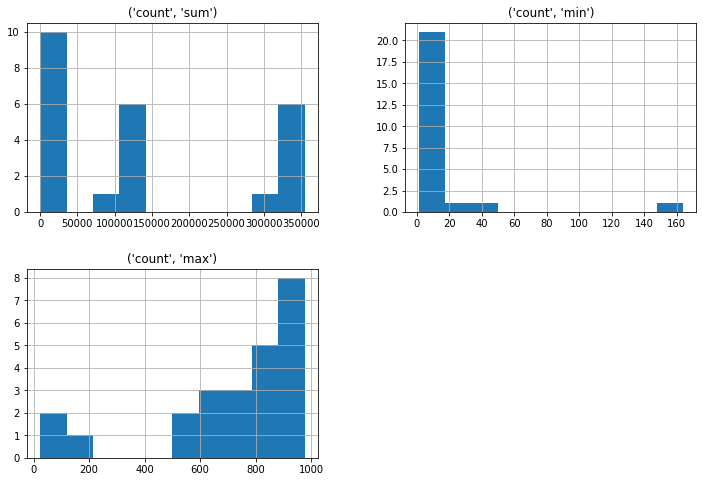

In [44]:
raw_fe1.groupby(['weather', 'DayofWeek']).agg({'count': [sum, min, max]}).hist(grid = True, figsize = (12, 8))
plt.show()